In [43]:
import torch
from torch_geometric.data import Data

In [44]:
from torch_geometric.datasets import QM9

# Initialize the QM9 dataset
data = QM9(root='./QM9')

data = data[0]
print(data.y)


tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])


In [103]:
# Import libraries
import torch
from torch.utils.data import Dataset
from torch_geometric.datasets import QM9
from torch.utils.data import DataLoader

# Dataset class
class QM9Dataset(Dataset):
    # Initialize the dataset object
    def __init__(self, data, y_index=0):
        self.dataset = data
        self.y_index = y_index

    # Return the length of the dataset
    def __len__(self):
        return len(self.dataset)
    
    # Return the item at the given index
    def __getitem__(self, index):
        batch = self.dataset[index]

        # Get the atomic numbers and coordinates
        atomic_numbers = batch.z
        coords = batch.pos

        # q = atomic_numbers copied 3 times 
        q = [num.item() for num in atomic_numbers for _ in range(3)]

        # R_ij = 3x(len(atomic_numbers) * 3))
        r_ij = torch.zeros((3, len(atomic_numbers) * 3))

        # Get the distance between atoms
        for i in range(r_ij.shape[0]):
            for j in range(r_ij.shape[1]):
                r_ij[i][j] = coords[j//3][i] - coords[j%3][i]

        # Variable to predict
        y = batch.y[0][self.y_index]

        # Combine the atomic numbers, coordinates and variable to predict
        return q, r_ij, y

def my_collate_fn(data):
        return data

# Function to create the dataset
def DataLoad(batch_size=1, shuffle=False, split=[0.8, 0.1, 0.1], y_index=0):
    # Create the dataset
    data = QM9(root='./QM9')

    # Create the dataset object
    dataset = QM9Dataset(data, y_index=0)

    # Train-test split
    train_size = int(split[0] * len(dataset))
    test_size = int(split[1] * len(dataset))
    val_size = len(dataset) - train_size - test_size

    train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

    # Create the train and test dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=my_collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=my_collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=my_collate_fn)

    return train_dataloader, test_dataloader, val_dataloader

In [107]:
max_size = 29 # Found previously

# Create the dataloaders
train, test, val = DataLoad(batch_size=1, shuffle=False, split=[0.8, 0.1, 0.1], y_index=0)

for i, batch in enumerate(train):
    print(batch[0][1].shape)
    break

torch.Size([3, 36])


In [13]:
# Simple GNN model
import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    # Initialize the model
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()

        # Initialize the linear layers
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    # Perform the forward pass
    def forward(self, x):
        '''x has shape (29, 4)'''
        # Apply the first linear layer
        x = self.linear1(x)

        # Apply ReLU non-linearity
        x = F.relu(x)

        # Apply the second linear layer
        x = self.linear2(x)

        return x


In [15]:
# Define the input dimension, hidden dimension and output dimension
input_dim = 4
hidden_dim = 32
output_dim = 1

# Initialize the model
model = GNN(input_dim, hidden_dim, output_dim)

# Define the loss function (norm)
loss_fn = nn.MSELoss()
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Number of epochs
n_epochs = 2

In [16]:
losses = []
y_preds = []

# Loop over the epochs
for epoch in range(n_epochs):
    # Training mode
    model.train()

    # Loop over each batch
    for batch in train:
        # Extract the atomic numbers, coordinates and y values
        atomic_numbers = batch[0][0]
        coords = batch[0][1]
        y = batch[0][2][0][0]

        # Standardize the input features so they have length 29
        # atomic_numbers = F.pad(atomic_numbers, (0, max_size - atomic_numbers.shape[0]))

        # Standardize coords so they have shape (29, 3)
        # coords = F.pad(coords, (0, 0, 0, max_size - coords.shape[0]))
        #print(coords)

        # Concatenate the atomic numbers and coordinates into one tensor (29, 4)
        empty = torch.zeros(max_size, 4)
        empty[:, 0] = atomic_numbers
        empty[:, 1:] = coords

        # Zero out the gradients
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = model(empty)
        y_preds.append(y_pred)

        # Compute the loss
        loss = loss_fn(y_pred, y)
        losses.append(loss)

        # Perform backward pass
        loss.backward()

RuntimeError: The expanded size of the tensor (29) must match the existing size (17) at non-singleton dimension 0.  Target sizes: [29].  Tensor sizes: [17]

[207.0314   329.45303  260.15     ...  29.964243  75.541916  17.25205 ]


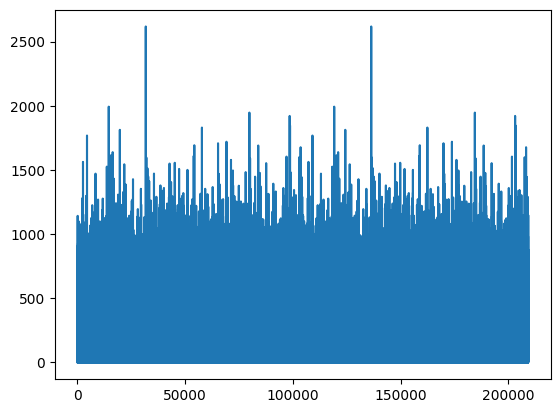

In [223]:
# plot the losses
import matplotlib.pyplot as plt
import numpy as np

# Detach the losses
nplosses = [x.detach().numpy() for x in losses]

# Mean loss per batch
nplosses = np.array(nplosses)
nplosses = nplosses.reshape(-1, 1)
nplosses = np.mean(nplosses, axis=1)
print(nplosses)

plt.plot(nplosses)
plt.show()

In [206]:
print(
    losses
)

[1.6552526 5.1056666 0.8112104 ... 7.825232  0.8025882 9.012954 ]
